In [1]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, DDIMScheduler
import torch.nn.functional as nnf
from PIL import Image
import numpy as np
from torch.optim.adam import Adam

In [2]:
torch.cuda.empty_cache()
device = torch.device('cuda:0')
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-seg")
ldm_stable = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", use_safetensors=True, controlnet=controlnet)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [3]:
def view_noise(noise):
	noise2 = noise.detach().clone().cpu()
	noise2 = (noise2 / 4 + 0.5).clamp(0, 1)
	noise2 = noise2.cpu().permute(0, 2, 3, 1).numpy()
	noise2 = (noise2 * 255).astype(np.uint8)
	noise2 = Image.fromarray(noise2[0]).convert('RGB')
	display(noise2)

def return_noise(noise, channel=None):
	noise2 = noise.detach().clone().cpu()
	noise2 = (noise2 / 4 + 0.5).clamp(0, 1)
	noise2 = noise2.cpu().permute(0, 2, 3, 1).numpy()
	noise2 = (noise2 * 255).astype(np.uint8)
	if channel is not None:
		for i in range(4):
			if i != channel:
				noise2[:, :, :, i] = noise2[:, :, :, channel]
	noise2 = Image.fromarray(noise2[0]).resize((256, 256), Image.NEAREST).convert('RGB')
	return noise2

def view_noise_channels(noise):
	noise2 = noise.detach().clone().cpu()
	noise2 = (noise2 / 4 + 0.5).clamp(0, 1)
	noise2 = noise2.cpu().permute(0, 2, 3, 1).numpy()
	noise2 = (noise2 * 255).astype(np.uint8)
	channels = np.concatenate([noise2[0, :, :, i] for i in range(4)], axis=1)
	channels = Image.fromarray(channels).resize((1024, 256), Image.NEAREST).convert('RGB')
	display(channels)

def latent2image(vae, latents):
    with torch.no_grad():
        latents = 1 / 0.18215 * latents
        image = vae.decode(latents)['sample']
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        image = (image * 255).astype(np.uint8)
    return image

def image2latent(vae, image):
    with torch.no_grad():
        if type(image) is Image:
            image = np.array(image)
        if type(image) is torch.Tensor and image.dim() == 4:
            latents = image
        else:
            image = torch.from_numpy(image).float() / 127.5 - 1
            image = image.permute(2, 0, 1).unsqueeze(0).to(vae.device)
            latents = vae.encode(image)['latent_dist'].mean
            latents = latents * 0.18215
    torch.cuda.empty_cache()
    return latents

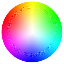

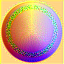

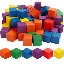

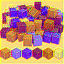

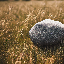

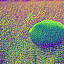

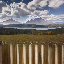

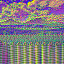

In [26]:
training_images = []
training_images.append(Image.open("colour wheel.png").convert('RGB'))
training_images.append(Image.open("colours.png").convert('RGB'))
training_images.append(Image.open("rock_img.png").convert('RGB'))
training_images.append(Image.open("vista.png").convert('RGB'))
latents = []
for img in training_images:
	latents.append(image2latent(ldm_stable.vae, np.array(img)))
training_images_small = [img.resize((64, 64), Image.NEAREST) for img in training_images]
for i in range(len(training_images)):
	display(training_images_small[i])
	view_noise(latents[i])

In [27]:
training_points = [torch.flatten(torch.tensor(np.array(img)).permute(2,0,1), 1).float() for img in training_images_small]
training_points = torch.cat(training_points, 1).permute(1,0).to(device)
print(training_points.size())
latent_points = [torch.flatten(latent, 2).squeeze() for latent in latents]
latent_points = torch.cat(latent_points, 1).permute(1,0).to(device)
print(latent_points.size())

torch.Size([16384, 3])
torch.Size([16384, 4])


In [28]:
# fully connected NN, batch size, in=4, out=3

class FCNN(torch.nn.Module):

	def __init__(self, in_features=4, out_features=3):
		super(FCNN, self).__init__()
		self.fc = torch.nn.Linear(in_features, out_features)

	def forward(self, x):
		return self.fc(x)

In [44]:
model = FCNN().to(device)
optimizer = Adam(model.parameters(), lr=0.005)

In [45]:
#training loop

for i in range(50000):
	optimizer.zero_grad()
	output = model(latent_points)
	loss = nnf.mse_loss(output, training_points)
	loss.backward()
	optimizer.step()
	if i % 1000 == 0:
		print(f"Epoch {i}: Loss: {loss.item()}")

#print weights and bias
print(model.fc.weight)
print(model.fc.bias)

Epoch 0: Loss: 25995.01171875
Epoch 1000: Loss: 22264.412109375
Epoch 2000: Loss: 19028.54296875
Epoch 3000: Loss: 16214.818359375
Epoch 4000: Loss: 13774.6201171875
Epoch 5000: Loss: 11673.646484375
Epoch 6000: Loss: 9882.59765625
Epoch 7000: Loss: 8368.7060546875
Epoch 8000: Loss: 7092.58935546875
Epoch 9000: Loss: 6017.193359375
Epoch 10000: Loss: 5109.79052734375
Epoch 11000: Loss: 4343.87841796875
Epoch 12000: Loss: 3702.1640625
Epoch 13000: Loss: 3168.5703125
Epoch 14000: Loss: 2729.3349609375
Epoch 15000: Loss: 2368.013916015625
Epoch 16000: Loss: 2066.1181640625
Epoch 17000: Loss: 1812.690673828125
Epoch 18000: Loss: 1600.099609375
Epoch 19000: Loss: 1421.0032958984375
Epoch 20000: Loss: 1272.564208984375
Epoch 21000: Loss: 1152.7747802734375
Epoch 22000: Loss: 1059.20068359375
Epoch 23000: Loss: 989.1181640625
Epoch 24000: Loss: 939.0867919921875
Epoch 25000: Loss: 905.29296875
Epoch 26000: Loss: 884.2355346679688
Epoch 27000: Loss: 872.541748046875
Epoch 28000: Loss: 867.0604

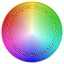

In [46]:
first_latent = latent_points[:(latent_points.size()[0]//len(latents)),:]
out = model(first_latent)
out = out.reshape(64, 64, 3).clamp(0,255)
display(Image.fromarray(out.detach().cpu().numpy().astype(np.uint8)))